In [72]:
# Import libraries
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from datetime import datetime, time, timedelta
import pandas_ta as ta

In [73]:
timeframe = 5
range_duration = 15
timeframe_code = f"M{timeframe}"
symbols = ["SPX500"]
systems = ["Strat"]
starting_balance = 100
risk_per_trade = 0.02 # Risking 2% per trade

range_start_time = time(9, 30)
range_end_time = (datetime.combine(datetime.today(), range_start_time) + timedelta(minutes=range_duration)).time()
latest_entry_time = time(11, 59)
market_close_time = time(16, 45)

trade_direction = "long"
timezone = "America/New_York"

exit_eod = False
trailing_stop = False
take_partial = False
trailing_multiplier = 1.5

In [74]:
# Load CSV File
def get_price_data(symbol):
    df = pd.read_csv(f"../data/{symbol}_{timeframe_code}.csv", parse_dates=['Datetime'], index_col='Datetime')
    df.index = pd.to_datetime(df.index, utc=True).tz_convert(timezone)  # Keeps local timezone without converting to UTC
    return df

In [75]:
def calculate_inputs(df):
  
    # Ensure the Datetime column is a datetime object
    df.index = pd.to_datetime(df.index)
    df['Date'] = df.index.date
    df['Time'] = df.index.time
    df['Last_Candle'] = df['Date'] != df['Date'].shift(-1)
    
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=(14))

    # Inside Bar Strength (IBS): where the close is within the candle's range
    df['IBS'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])
    df['IBS'] = df['IBS'].fillna(0)  # in case High == Low

    # Filter the DataFrame for the opening range period
    df_open_range = df[(df['Time'] >= range_start_time) & (df['Time'] < range_end_time)]
    
    # Group by each trading day and calculate the high and low for that range
    opening_range = df_open_range.groupby('Date').agg(
        Open_Range_High=('High', 'max'),
        Open_Range_Low=('Low', 'min')
    )

    # Determine if the opening candle is bullish: Close > Open
    df_open_range = df[df['Time'] == range_start_time].copy()
    
    # Merge the opening range back to the original DataFrame without resetting the index
    df = df.join(opening_range, on='Date')
   
    df = df.drop(['Time', 'Date'], axis=1)

    return df

In [76]:
def generate_signals(df, s, atr_sl, tp_ratio):
    # Get hour values
    df["Hour"] = df.index.hour
    df["Minute"] = df.index.minute
    df['Date'] = df.index.date
    

    midline = False
    limit_order = False
    one_daily = False
    
    df['Open_Range_Width'] = df['Open_Range_High'] - df['Open_Range_Low']
    df['Open_Range_Mid'] = (df['Open_Range_Low'] + df['Open_Range_High']) / 2

    df['Breakout_Above'] = np.where(df.index.time >= range_end_time, df['Close'] - df['Open_Range_High'], 0)
    df['Breakout_Above'] = df['Breakout_Above'].clip(lower=0)

    def resettable_cummax(series, condition):
        max_val = 0.0
        results = []
        for val, cond in zip(series, condition):
            if not cond:  # condition false → reset
                max_val = 0.0
            else:
                max_val = max(max_val, val)
            results.append(max_val)
        return pd.Series(results, index=series.index)

    if midline:
        condition = df['Close'] > df['Open_Range_Mid']
    else:
        condition = df['Close'] > df['Open_Range_High']

    df['Max_Breakout'] = df.groupby('Date', group_keys=False).apply(
        lambda g: resettable_cummax(g['Breakout_Above'], condition.loc[g.index]),
        include_groups=False
    )

    # 1. Breakout confirmed column
    breakout_threshold = 1.0
    if midline:
        df['Breakout_Confirmed'] = (
            (df['Max_Breakout'] > df['ATR'] * breakout_threshold) &
            (df['Close'] > df['Open_Range_Mid'])
        )
        # 2. Pullback confirmed column (only true if prev candle had breakout confirmed)
        df['Pullback_Confirmed'] = (
            (df['Open'] > df['Open_Range_Mid']) &
            (df['Low'] < df['Open_Range_Mid']) &
            (df['Breakout_Confirmed'].shift(1))
        )
    else:
        df['Breakout_Confirmed'] = (
            (df['Max_Breakout'] > df['ATR'] * breakout_threshold) &
            (df['Close'] > df['Open_Range_High'])
        )
        # 2. Pullback confirmed column (only true if prev candle had breakout confirmed)
        df['Pullback_Confirmed'] = (
            (df['Open'] > df['Open_Range_High']) &
            (df['Low'] < df['Open_Range_High']) &
            (df['Breakout_Confirmed'].shift(1))
        )

    # --- Restrict to one signal per day ---
    def restrict_one_signal(g):
        if g['Pullback_Confirmed'].any():
            first_idx = g[g['Pullback_Confirmed']].index[0]
            g.loc[g.index > first_idx, 'Breakout_Confirmed'] = False
            g.loc[g.index > first_idx, 'Pullback_Confirmed'] = False
        return g

    if one_daily:
        df = df.groupby('Date', group_keys=False).apply(restrict_one_signal)
    
    # Various entry conditions
    c1_long = (df['Open'] <= df['Open_Range_High']) & (df['Close'] > df['Open_Range_High'])  # Breakout above opening range (long signal)
    c1_short = (df['Open'] >= df['Open_Range_Low']) & (df['Close'] < df['Open_Range_Low'])  # Breakout below opening range (short signal)

    c2 = (df.index.time >= range_end_time) & (df.index.time < market_close_time)
    c3 = df['Open_Range_High'].notna() # Check that the current candle actually has a range. The sunday candles on CFDs can open in the evening
    c4 = df.index.time <= latest_entry_time
    c5 = df['ATR'].notna()

    c6 = df['Pullback_Confirmed']
    c7 = df['High'] > df['High'].shift(1) # Continuation candle - high is greater than previous high
    c8 = df['IBS'] > 0.0#8
    
    #generate entries and exits
    #entry is taken if the conditions were met at yesterday's close
    # Entries depend on the strategy

    # Stop loss type
    range_stop = True
    if s == "Strat":
        if trade_direction == "long":
            # default entry rules
            if limit_order:
                df[f"{s}_Signal"] = c2 & c3 & c4 & c5 & c6 & c8.shift(1)
                if midline:
                    df['Entry_Price'] = df['Open_Range_Mid']
                else:
                    df['Entry_Price'] = df['Open_Range_High']
            else:
                df[f"{s}_Signal"] = c2 & c3 & c4 & c5 & c6.shift(1) & c7 & c8.shift(1)
                df['Entry_Price'] = df['High'].shift(1)
            # Generate exits
            stop_size = df['Entry_Price'] - df['Open_Range_Low']
            if range_stop == True:
                df['SL'] = df['Entry_Price'] - stop_size * atr_sl
            else:
                df['SL'] = df['Low'].shift(1)
            stop_dist = df['Entry_Price'] - df['SL']
            df['TP'] = df['Entry_Price'] + stop_dist * tp_ratio
        elif trade_direction == "short":
            df[f"{s}_Signal"] = c1_short.shift(1) & c2 & c3 & c4 & c5.shift(1)
            # Generate exits
            stop_size = df['Open_Range_High'] - df['Open']
            df['SL'] = df['Open'] + stop_size * atr_sl
            stop_dist = df['SL'] - df['Open']
            df['TP'] = df['Open'] - stop_dist * tp_ratio

    return df

In [77]:
def generate_trades(df, s, mult):
    #create empty list for trades
    trades_list = []
    trade_open = False
    open_change = {}
    balance = starting_balance
    equity = starting_balance
    balance_history = []
    equity_history = []
    trailing = False

    # Extract numpy arrays for relevant columns
    open_prices = df['Open'].values
    high_prices = df['High'].values
    low_prices = df['Low'].values
    close_prices = df['Close'].values
    entry_prices = df['Entry_Price'].values
    atr_values = df['ATR'].values if 'ATR' in df.columns else None
    prev_atr_values = df['ATR'].shift(1).values if 'ATR' in df.columns else None
    sl_values = df['SL'].values
    tp_values = df['TP'].values
    signal_values = df[f"{s}_Signal"].values
    range_high = df['Open_Range_High'].values
    range_low = df['Open_Range_Low'].values
    last_candle_values = df['Last_Candle'].values
    index_values = df.index
    
    #iterate through rows to work out entries and exits
    for i in range(len(df)):
        #if there is currently no trade
        if not trade_open and signal_values[i]:
            entry_date = index_values[i]
            entry_price = entry_prices[i]
            sl = sl_values[i]
            tp = tp_values[i]
            # Calculate position size based on risk percentage
            risk_amount = balance * risk_per_trade
            position_size = 0.01 if entry_price == sl else risk_amount / abs(entry_price - sl)
            trade_open = True
            trailing = False
            entry_bar_index = i  # <--- track which bar you entered
        #check if a trade is already open
        if trade_open:
            #get price values
            low = low_prices[i]
            high = high_prices[i]
            open = open_prices[i]
            close = close_prices[i]
            last_candle = last_candle_values[i]

            if trade_direction == "long":
                # Calculate unrealized PnL
                floating_pnl = (high - entry_price) * position_size
                equity = balance + floating_pnl  # Update equity dynamically

                # Calculate unrealized PnL
                #check if stop is hit
                if low <= sl:
                    exit_price = open if open <= sl else sl
                    trade_open = False

                # Now do the same check for take profit
                elif i != entry_bar_index and high >= tp:
                    if trailing_stop:
                        trailing = True
                        if take_partial:
                            partial_exit_price = open if open >= tp else tp
                            position_size *= 0.5
                            pnl = (partial_exit_price - entry_price) * position_size  # PnL in currency terms
                            balance += pnl  # Update balance with PnL
                        tp = 100000000000
                    else:
                        exit_price = open if open >= tp else tp
                        trade_open = False

                elif exit_eod:
                    if (index_values[i].time() == market_close_time) or last_candle:
                        exit_price = close  # Close at the market close price
                        trade_open = False

                # Update trailing stop
                elif trailing:
                    new_stop = open - (prev_atr_values[i] * mult)
                    if new_stop > sl:
                        sl = new_stop

            elif trade_direction == "short":
                floating_pnl = (entry_price - low) * position_size
                equity = balance + floating_pnl  # Update equity dynamically

                # Calculate unrealized PnL
                #check if stop is hit
                if high >= sl:
                    #first check for a gap down
                    if open >= sl:
                        exit_price = open
                    else:
                        exit_price = sl
                    trade_open = False

                # Now do the same check for take profit
                elif low <= tp:
                    #first check for a gap up
                    if open <= tp:
                        exit_price = open
                    else:
                        exit_price = tp
                    trade_open = False

                elif exit_eod:
                    if (i.time() == market_close_time) or row.Last_Candle:
                        exit_price = row.Close  # Close at the market close price
                        trade_open = False

            if not trade_open: # If trade has been closed
                exit_date = index_values[i]
                trade_open = False
                if trade_direction == "long":   
                    pnl = (exit_price - entry_price) * position_size  # PnL in currency terms
                elif trade_direction == "short":
                    pnl = -1 * (exit_price - entry_price) * position_size # PnL in currency terms
                balance += pnl  # Update balance with PnL             

                #store trade data in a list
                trade = [entry_date, entry_price, exit_date, exit_price, position_size, pnl, balance, True]
                #append trade to overall trade list
                trades_list.append(trade)

        # Store balance and equity
        balance_history.append(balance)
        equity_history.append(equity)

    trades = pd.DataFrame(trades_list, columns=["Entry_Date", "Entry_Price", "Exit_Date", "Exit_Price", "Position_Size", "PnL", "Balance", "Sys_Trade"])
    
    #calculate return of each trade as well as the trade duration
    trades[f"{s}_Return"] = trades.Balance / trades.Balance.shift(1)
    dur = []
    for i, row in trades.iterrows():
        d1 = row.Entry_Date
        d2 = row.Exit_Date
        dur.append(np.busday_count(d1.date(), d2.date()) + 1)#Add 1 because formula doesn't include the end date otherwise
    
    trades[f"{s}_Duration"] = dur

    #create a new dataframe with an index of exit dfs
    returns = pd.DataFrame(index=trades.Exit_Date)
    #create a new dataframe with an index of entries to track entry price
    entries = pd.DataFrame(index=trades.Entry_Date)

    entries[f"{s}_Entry_Price"] = pd.Series(trades.Entry_Price).values
    #add the Return column to this new data frame
    returns[f"{s}_Ret"] = pd.Series(trades[f"{s}_Return"]).values
    returns[f"{s}_Trade"] = pd.Series(trades.Sys_Trade).values
    returns[f"{s}_Duration"] = pd.Series(trades[f"{s}_Duration"]).values
    returns[f"{s}_PnL"] = pd.Series(trades.PnL).values
    returns[f"{s}_Balance"] = pd.Series(trades.Balance).values
    change_ser = pd.Series(open_change, name=f"{s}_Change")

    #add the returns from the trades to the main data frame
    df = pd.concat([df, returns, entries, change_ser], axis=1)
    #fill all the NaN return values with 1 as there was no profit or loss on those days
    df[f"{s}_Ret"] = df[f"{s}_Ret"].fillna(1)
    #fill all the NaN trade values with False as there was no trade on those days
    df[f"{s}_Trade"] = df[f"{s}_Trade"].infer_objects(copy=False)
    #fill all the NaN return values with 1 as there was no loss on those days
    df[f"{s}_Change"] = df[f"{s}_Change"].astype(float).fillna(1)
    
    #use the updated balance and equity variables
    df[f"{s}_Bal"] = pd.Series(balance_history, index=df.index).ffill()
    df[f"{s}_Equity"] = pd.Series(equity_history, index=df.index).ffill()

    active_trades = np.where(df[f"{s}_Trade"] == True, True, False)
    df[f"{s}_In_Market"] = df[f"{s}_Trade"].copy()
    #populate trades column based on duration
    for count, t in enumerate(active_trades):
        if t == True:
            dur = df[f"{s}_Duration"].iat[count]
            for i in range(int(dur)):
                #starting from the exit date, move backwards and mark each trading day
                df[f"{s}_In_Market"].iat[count - i] = True
    
    return df, trades

In [78]:
def backtest(price, atr_sl, tp_ratio, mult):
    #calculate strategy inputs
    price = calculate_inputs(price)

    for s in systems:
        #generate signals
        price = generate_signals(price, s, atr_sl, tp_ratio)

        #generate trades
        price, trades = generate_trades(price, s, mult)

    for s in systems:
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]

    return price, trades

In [79]:
results = []
prog = 0
sl_range = np.arange(1.0, 1.5, 0.5)
tp_range = np.arange(1.5, 2.0, 0.5)
multipliers = np.arange(1.0, 1.5, 0.5)
max_prog = len(symbols) * len(sl_range) * len(tp_range) * len(multipliers)
for sym in symbols:
    price = get_price_data(sym)
    for atr_sl in sl_range:
        for tp_ratio in tp_range:
            for mult in multipliers:
                result, trades = backtest(price, atr_sl, tp_ratio, mult)
                results.append(result)
                prog += 1
                #clear_output(wait=True)
                print(f"Progress: {round((prog / max_prog) * 100)} %")

Progress: 100 %


In [80]:
def get_metrics(system, data):
    metrics = {}
    years = (data.index[-1] - data.index[0]).days / 365.25
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
 
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    trades_triggered = data[f"{system}_Trade"].sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    #metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    metrics["Winrate"] = round(winrate, 2)
    metrics["Avg_RR"] = avg_rr

    return metrics

In [81]:
for count, res in enumerate(results):
    sys_metrics = {}
    for s in systems:
        sys_metrics.update({s: get_metrics(s, res)})
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)

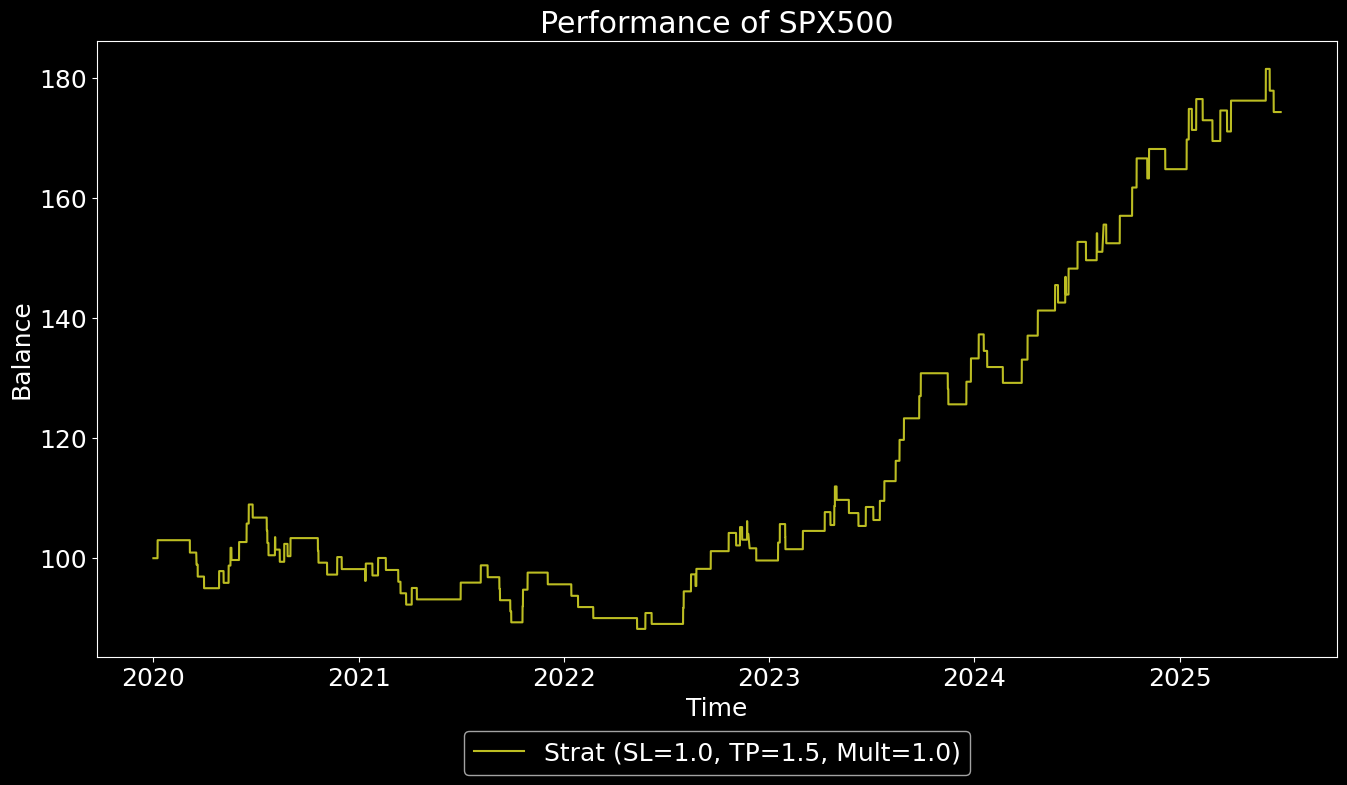

In [82]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({"font.size": 18})

colours = ["tab:olive", "tab:blue", "tab:purple", "tab:orange", "tab:green", "tab:cyan", "tab:red", "tab:gray", "tab:pink"]

for count, sym in enumerate(symbols):
    plt.figure()
    plt.title(f"Performance of {sym}")

    legend_entries = []  # Store legend labels
    colour_idx = 0  # To cycle through colors if needed

    for atr_sl in sl_range:
        for tp_ratio in tp_range:
            for mult in multipliers:
                for c, s in enumerate(systems):
                    # Generate a unique index for each (SL, TP) combination
                    result_idx = (
                        count * len(sl_range) * len(tp_range) * len(multipliers)
                        + list(sl_range).index(atr_sl) * len(tp_range) * len(multipliers)
                        + list(tp_range).index(tp_ratio) * len(multipliers)
                        + list(multipliers).index(mult)
                    )

                    if result_idx >= len(results):  
                        continue  # Prevent out-of-bounds error

                    label = f"{s} (SL={atr_sl}, TP={tp_ratio}, Mult={mult})"
                    color = colours[colour_idx % len(colours)]
                    
                    plt.plot(results[result_idx][f"{s}_Bal"], color=color, label=label)
                    legend_entries.append(label)

                    colour_idx += 1  # Move to next color

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.xlabel("Time")
    plt.ylabel("Balance")
    #plt.grid(True, linestyle="--", alpha=0.5)
    plt.savefig("plot.png", format="png", dpi=300, bbox_inches="tight")
    plt.show()




In [83]:
print(sys_metrics_df)

                Strat
Start_Balance  100.00
Final_Balance  174.32
Annual_Return   10.65
Max_Drawdown   -19.02
Trades         130.00
Winrate         48.84
Avg_RR           1.50


In [84]:
# Split index into 'Date' and 'Time' columns
trades['Entry_Date'] = pd.to_datetime(trades["Entry_Date"])
trades['Entry_Hour'] = trades['Entry_Date'].dt.hour

# Convert "Strat_Breakout_Return" to percentage
trades["Return_Percentage"] = (trades[f"{systems[-1]}_Return"] - 1) * 100

# Group by Hour and Calculate Average PnL
hourly_return = trades.groupby("Entry_Hour")["Return_Percentage"].mean()

# Group by Hour and Count Number of Trades
hourly_trades_count = trades.groupby("Entry_Hour")["Return_Percentage"].count()

# Combine the two results into a single DataFrame
hourly_stats = pd.DataFrame({
    "Average_Return_Percentage": hourly_return,
    "Trades_Count": hourly_trades_count
})

# Display Result
print(hourly_stats)

            Average_Return_Percentage  Trades_Count
Entry_Hour                                         
9                            1.350000             3
10                           0.584270            89
11                           0.018657            37


In [85]:
trades.to_csv("trades.csv")
result.to_csv("result.csv")